The following notebook outlines the state of the lick/groom CNN model as of May 24, 2021.  

The repository containing the lick/groom CNN model is here:
https://github.com/AllenInstitute/lick_detection_cnn

The model was last trained in May of 2021. As of May, there are  24,550 annotated frames, distributed as follows:

* lick: 8,537
* groom: 1,307
* neither: 14,587
* ambiguous: 119 (these were frames that annotaters could not label and they were excluded from training)

So clearly the model is doing reasonably well on the held out test data. But as shown below, the model is still struggling under some circumstances. I think it is good enough for drawing broad conclusions about licking/grooming patterns, but it might still benefit from another round of annotation and training, with focus being on getting more passive session data and mesoscope data into the training set.

Doug Ollerenshaw

In [1]:
from visual_behavior.data_access import loading, from_lims
from multiprocessing import Pool
import pandas as pd
import visual_behavior.utilities as vbu
import visual_behavior.database as db
import matplotlib.pyplot as plt
import glob
import os
import seaborn as sns
import scipy 

from lick_detection_cnn.visualize import visualize_predictions
from lick_detection_cnn.lick_detection_model import LickDetectionModel, Generators
from lick_detection_cnn import evaluation

import visual_behavior.utilities as vbu
import visual_behavior.database as db
import scipy.misc
import numpy as np
import pandas as pd


import cv2

from tqdm import tqdm

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

%matplotlib inline

Using TensorFlow backend.


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%matplotlib notebook

# start with some basic model characterization

## define paths

In [4]:
weights_path = '/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/lick_detection_model/model_weights_checkpoint_2021-05-07T23_33_55.197649_n_gpus=1.h5'
image_path = '/local/lick_detection_model/lick_groom_model'

## load the csv that contains the record of frames used for training

In [5]:
all_image_table = pd.read_csv('~/code/lick_detection_cnn/support_files/train_test_validate_table.csv')
all_image_table

frame_number    label  session_id train_test_validate
0              9000  neither   976167513            validate
1             41599     lick  1004014391                test
2             41598     lick  1004014391               train
3             41597     lick  1004014391               train
4             41596     lick  1004014391               train
...             ...      ...         ...                 ...
26948        117313    groom  1011877572               train
26949        117621    groom  1011877572               train
26950          6225    groom  1012635881               train
26951         98104    groom  1012635881               train
26952         27978    groom  1013000229                test

[26953 rows x 4 columns]

### get the count by label

In [6]:
pd.DataFrame(all_image_table['label'].value_counts()).rename(columns = {'label':'annotation count'})

annotation count
neither               15489
lick                   9025
groom                  2320
ambiguous               119

### get the count by label and train/test/validate split

In [7]:
all_image_table.query('label != "ambiguous"').groupby(['label', 'train_test_validate'])[['frame_number']].count().rename(columns = {'frame_number':'annotation count'})

annotation count
label   train_test_validate                  
groom   test                              235
        train                            1857
        validate                          228
lick    test                              945
        train                            7180
        validate                          900
neither test                             1545
        train                           12407
        validate                         1537

## load the model

In [8]:
model = LickDetectionModel(weights_path=weights_path).model
generators = Generators(image_path , batch_size=16)


ONLY USING ONE GPU!
loading weights from: /allen/programs/braintv/workgroups/nc-ophys/visual_behavior/lick_detection_model/model_weights_checkpoint_2021-05-07T23_33_55.197649_n_gpus=1.h5


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/lick_detection_cnn/lick_detection_cnn/lick_detection_model.py:58: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  model = Model(input=base_model.input, output=predictions)


Found 21444 images belonging to 3 classes.
Found 148 images belonging to 3 classes.
Found 2665 images belonging to 3 classes.
Found 2725 images belonging to 3 classes.


## get the predictions summary

In [ ]:
predictions_summary = evaluation.make_prediction_summary(model, generators.test_generator)

In [ ]:
predictions_summary.sample(10)

### get the confusion matrix on the test set

In [ ]:
cm = evaluation.get_confusion_matrix(model, generators.test_generator, normalize=False)
cm

In [ ]:
cm = evaluation.get_confusion_matrix(model, generators.test_generator, normalize=True)
cm

# look at model performance across session types

## load the experiment table, get a list of session IDs

In [9]:
et = loading.get_filtered_ophys_experiment_table(release_data_only=True).reset_index()
osids = et.drop_duplicates(subset = 'ophys_session_id')['ophys_session_id']

## add a column called `session_type_simple` that allows us to lump all of the OPHYS_N sessions together

In [10]:
et['session_type_simple'] = et['session_type'].map(lambda st: st.split('_')[0] + '_' + st.split('_')[1])

## a function to load the lick/groom predictions, adding a column with the session ID

In [11]:
def load_lick_groom_predictions(osid):
    try:
        session = loading.get_ophys_dataset(from_lims.get_ophys_experiment_ids_for_ophys_session_id(osid).iloc[0][0])
        preds = session.behavior_movie_predictions.copy()
        preds['ophys_session_id'] = osid
        return preds.reset_index()
    except Exception as e:
        return pd.DataFrame()

## Now load the lick/groom predictions for all sessions, the concatenate them

In [12]:
with Pool(32) as pool:
    preds_list = pool.map(load_lick_groom_predictions, osids)

In [13]:
df = pd.concat(preds_list)
len(df)

65184656

## merge in some identifying info, then ensure that the length hasn't changed.

In [14]:
preds_df = df.merge(
    et[['ophys_session_id','session_type','session_type_simple','cre_line','equipment_name']].drop_duplicates(subset = 'ophys_session_id'),
    left_on = 'ophys_session_id',
    right_on = 'ophys_session_id',
    how = 'left'
)

In [15]:
len(preds_df)


65184656

## add a column with experiment time in minutes, as an integer. This will be useful for grouping by minute.

In [16]:

preds_df['minutes'] = preds_df['timestamps']/60
preds_df['minutes'] = preds_df['minutes'].astype(int)

In [17]:
preds_df.sample(10)

frame_index         groom          lick   neither  timestamps  \
27579629        39309  2.050570e-03  9.795383e-01  0.018411  1310.54640   
53118501        51781  4.087212e-05  6.123183e-01  0.387641  1726.28584   
7046851        106819  2.664421e-10  8.718456e-10  1.000000  3561.85913   
33217146        67658  7.623647e-07  7.974157e-06  0.999991  2255.46560   
46567550         6222  1.390020e-09  3.072363e-09  1.000000   207.68273   
1187876         92468  2.395130e-08  2.702715e-08  1.000000  3082.41421   
19004089        57449  3.173458e-10  3.045155e-12  1.000000  1915.18628   
13166633       104777  2.099582e-06  2.063912e-05  0.999977  3492.97576   
58016753        50065  5.346067e-06  3.538932e-05  0.999959  1669.24593   
45096774        94630  8.251521e-07  2.062850e-03  0.997936  3154.44311   

          ophys_session_id              session_type session_type_simple  \
27579629        1037717307          OPHYS_1_images_B             OPHYS_1   
53118501         792327341          OPHYS_1_images_A             OPHYS_1   
7046851          943299247          OPHYS_6_images_B             OPHYS_6   
33217146         981863572          OPHYS_4_images_A             OPHYS_4   
46567550         843049997  OPHYS_2_images_A_passive             OPHYS_2   
1187876          993727065          OPHYS_1_images_B             OPHYS_1   
19004089         962206869          OPHYS_3_images_A             OPHYS_3   
13166633         858863712          OPHYS_1_images_A             OPHYS_1   
58016753         806203732          OPHYS_1_images_A             OPHYS_1   
45096774        1005018474          OPHYS_4_images_A             OPHYS_4   

                   cre_line equipment_name  minutes  
27579629  Slc17a7-IRES2-Cre        CAM2P.3       21  
53118501  Slc17a7-IRES2-Cre        CAM2P.4       28  
7046851   Slc17a7-IRES2-Cre        CAM2P.3       59  
33217146       Sst-IRES-Cre        CAM2P.3       37  
46567550  Slc17a7-IRES2-Cre        CAM2P.3        3  
1187876        Sst-IRES-Cre        CAM2P.4       51  
19004089       Sst-IRES-Cre        CAM2P.5       31  
13166633  Slc17a7-IRES2-Cre        CAM2P.4       58  
58016753  Slc17a7-IRES2-Cre        CAM2P.4       27  
45096774       Vip-IRES-Cre        CAM2P.4       52

## Now make a new dataframe that is grouped by session ID and minute, taking the mean probabilities in each minute
Note that I identified one session ID with egregiously bad predictions - 994869518. This was a passive session where the lick probability was consistently near one, despite there clearly being no licks. I removed this from the grouped dataframe for now, but I should really sample some frames from this movie and feed them back into the model to improve training. There must be some particular feature in this movie that is distinct and is throwing off the model.`m

In [18]:
bad_ids = [] #[994869518] ## sessions with known bad predictions

preds_by_minute = preds_df.query('ophys_session_id not in @bad_ids').groupby(['ophys_session_id', 'minutes'])['lick','groom','neither'].mean().reset_index().merge(
    et[['ophys_session_id','session_type','session_type_simple','cre_line','equipment_name']].drop_duplicates(subset = 'ophys_session_id'),
    left_on = 'ophys_session_id',
    right_on = 'ophys_session_id',
    how = 'left'
)

## Make a function to plot the probability for each 1 minute bin

In [19]:
def plot_lick_prob_single_session_type(data_to_plot, ax, y_value, hue=None):
    sns.lineplot(
        data = data_to_plot,
        x = 'minutes',
        y = y_value,
        ax = ax,
        n_boot = 1000,
        hue=hue,
        legend=None,
        palette='Set2'
    )
    ax.set_xlim(0, 70)
#     ax.set_ylim(0, 0.125)
    ax.set_ylabel('mean\nlick\nprobability', rotation = 0, va='center', labelpad = 30)
    
    

def plot_lick_prob_by_minute(preds_by_minute, to_plot='lick', sharey=True, hue=None):
    
    fig, ax = plt.subplots(6, 1, figsize=(6,8), sharex=True, sharey=sharey)
    for session_number in range(6):
        data_to_plot = preds_by_minute.query('session_type_simple == "OPHYS_{}"'.format(session_number + 1))
        plot_lick_prob_single_session_type(data_to_plot, ax[session_number], y_value=to_plot, hue=hue)
        ax[session_number].set_title('session type = OPHYS_{}'.format(session_number + 1))
        
    fig.tight_layout()
    plt.subplots_adjust(top = 0.9)
    fig.suptitle('mean {} probability in one minute bins'.format(to_plot))
    
    return fig, ax

## plot licks for each 1 minute bin
A few things that stand out:
1. lick probability gradually declines in the active sessions, which matches with what we know about declining motivation.  
2. in the active sessions, you can see the onset of licking at the end of the gray screen period @ 5 minutes (i.e., when the actual task begins).  
3. in the passive sessions, there is very little licking in those first five minutes, which implies that pre-watered mice aren't eagerly trying to lick in those first few minutes.  

<IPython.core.display.Javascript object>


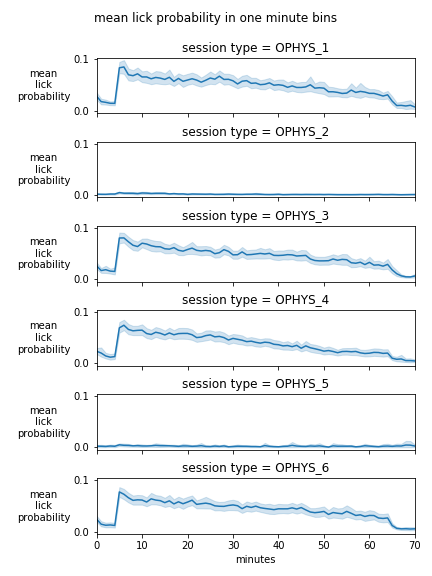

In [20]:
plot_lick_prob_by_minute(preds_by_minute, to_plot='lick');

<IPython.core.display.Javascript object>


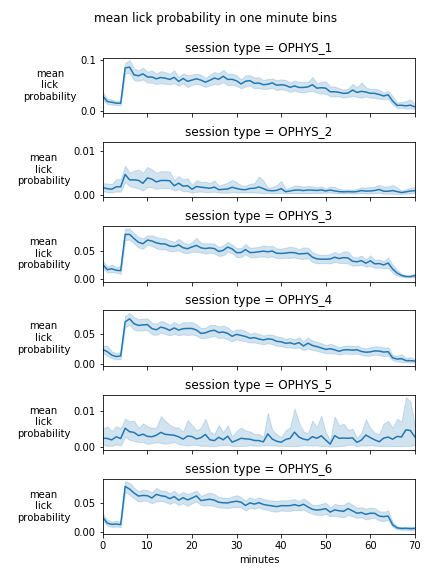

In [21]:
plot_lick_prob_by_minute(preds_by_minute, to_plot='lick', sharey=False);

### repeat the plot, but now with each session as a distinct line
This emphasizes some of the variability

<IPython.core.display.Javascript object>


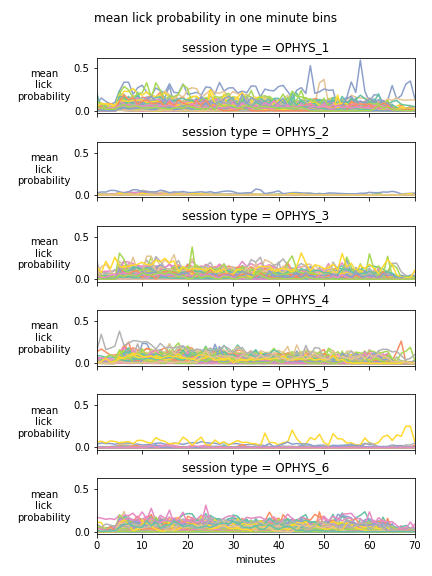

In [22]:
plot_lick_prob_by_minute(preds_by_minute, to_plot='lick', hue='ophys_session_id', sharey=True);

<IPython.core.display.Javascript object>


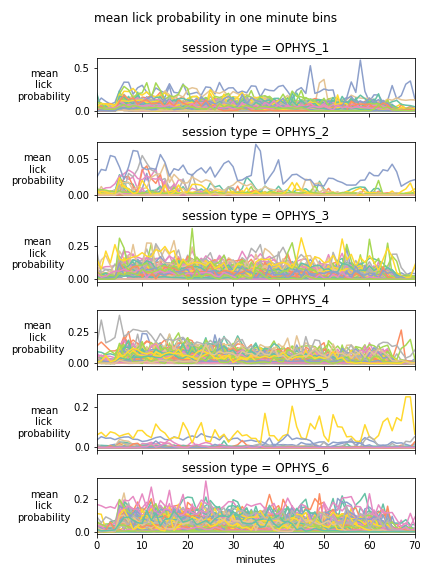

In [23]:
plot_lick_prob_by_minute(preds_by_minute, to_plot='lick', hue='ophys_session_id', sharey=False);

In [24]:
preds_by_minute

ophys_session_id  minutes          lick         groom   neither  \
0             775289198        0  7.991580e-03  3.334982e-05  0.991975   
1             775289198        1  2.182679e-03  3.420712e-05  0.997783   
2             775289198        2  9.731297e-04  3.901509e-05  0.998988   
3             775289198        3  4.704527e-04  1.961656e-05  0.999510   
4             775289198        4  9.390637e-04  3.730047e-05  0.999024   
...                 ...      ...           ...           ...       ...   
36485        1071202230       71  1.036310e-07  1.034376e-07  1.000000   
36486        1071202230       72  9.046886e-08  3.273362e-07  1.000000   
36487        1071202230       73  2.241418e-06  1.018187e-03  0.998980   
36488        1071202230       74  2.656360e-07  5.149475e-07  0.999999   
36489        1071202230       75  5.152125e-08  3.641666e-07  1.000000   

           session_type session_type_simple           cre_line equipment_name  
0      OPHYS_1_images_A             OPHYS_1  Slc17a7-IRES2-Cre        CAM2P.5  
1      OPHYS_1_images_A             OPHYS_1  Slc17a7-IRES2-Cre        CAM2P.5  
2      OPHYS_1_images_A             OPHYS_1  Slc17a7-IRES2-Cre        CAM2P.5  
3      OPHYS_1_images_A             OPHYS_1  Slc17a7-IRES2-Cre        CAM2P.5  
4      OPHYS_1_images_A             OPHYS_1  Slc17a7-IRES2-Cre        CAM2P.5  
...                 ...                 ...                ...            ...  
36485  OPHYS_6_images_B             OPHYS_6       Vip-IRES-Cre        CAM2P.4  
36486  OPHYS_6_images_B             OPHYS_6       Vip-IRES-Cre        CAM2P.4  
36487  OPHYS_6_images_B             OPHYS_6       Vip-IRES-Cre        CAM2P.4  
36488  OPHYS_6_images_B             OPHYS_6       Vip-IRES-Cre        CAM2P.4  
36489  OPHYS_6_images_B             OPHYS_6       Vip-IRES-Cre        CAM2P.4  

[36490 rows x 9 columns]

## plot grooming probabilities in 1 minute bins
These are pretty variable. There don't appear to be strong trends across active/passive, or for particular epochs where grooming is generally high

<IPython.core.display.Javascript object>


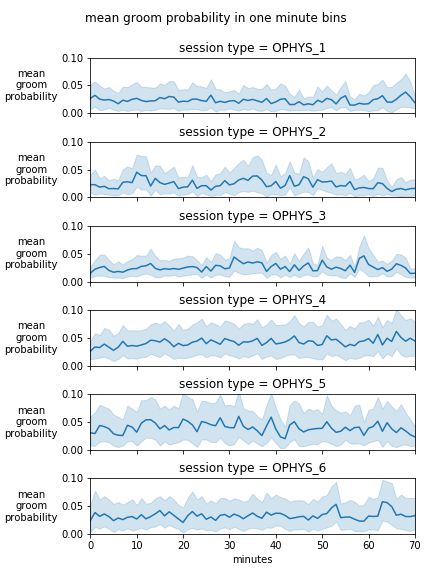

In [25]:
fig, ax = plot_lick_prob_by_minute(preds_by_minute, to_plot='groom', sharey=True);
ax[0].set_ylim(0, 0.1)
for axis in ax:
    axis.set_ylabel('mean\ngroom\nprobability')

<IPython.core.display.Javascript object>


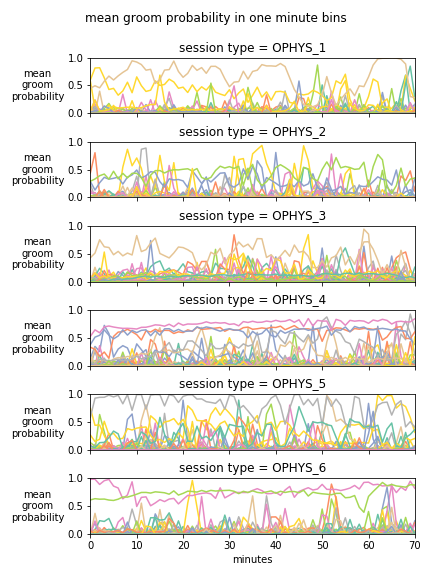

In [26]:
fig, ax = plot_lick_prob_by_minute(preds_by_minute, to_plot='groom', sharey=True, hue='ophys_session_id');
ax[0].set_ylim(0, 1)
for axis in ax:
    axis.set_ylabel('mean\ngroom\nprobability')

<IPython.core.display.Javascript object>


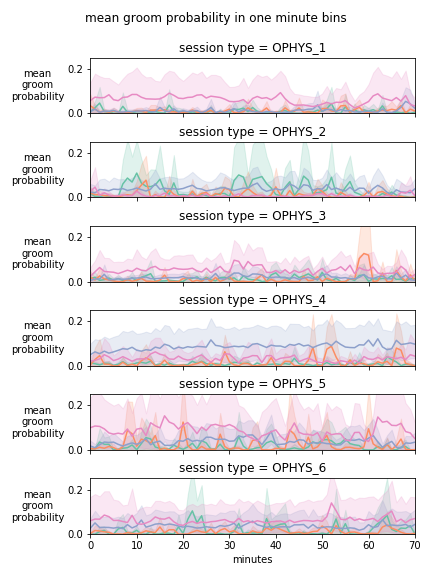

In [27]:
fig, ax = plot_lick_prob_by_minute(preds_by_minute, to_plot='groom', sharey=True, hue='equipment_name');
ax[0].set_ylim(0, 0.25)
for axis in ax:
    axis.set_ylabel('mean\ngroom\nprobability')

In [28]:
mean_probs = preds_df.groupby(['ophys_session_id'])[['lick','groom','neither']].mean().reset_index()
print(len(mean_probs))
mean_probs = mean_probs.merge(
    et,
    left_on = ['ophys_session_id'],
    right_on = ['ophys_session_id']
).drop_duplicates(subset=['ophys_session_id'])
print(len(mean_probs))

477
477


In [29]:
mean_probs.query('ophys_session_id == 1056065360').iloc[0]

ophys_session_id                                                      1056065360
lick                                                                    0.010797
groom                                                                   0.800195
neither                                                                 0.189008
ophys_experiment_id                                                   1056171522
equipment_name                                                            MESO.1
full_genotype                      Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt
mouse_id                                                                  528097
reporter_line                                         Ai148(TIT2L-GC6f-ICL-tTA2)
driver_line                                                       [Vip-IRES-Cre]
sex                                                                            F
age_in_days                                                                  187
cre_line                    

## a function to plot a single frame

In [30]:
def plot_frame(osid, frame_index, ax):
    v = db.get_well_known_files(osid).loc['RawBehaviorTrackingVideo']
    m = vbu.Movie(''.join((v['storage_directory'], v['filename'])))
    ax.imshow(m.get_frame(frame_index))

## a function to plot 10 sample frames from every session type for a given probability range

In [31]:
def plot_examples_by_session(to_plot, low_bound_prob, high_bound_prob = 1):
    n_cols = 10
    fig, ax = plt.subplots(6, n_cols, sharex=True, sharey=True, figsize = (20,10))
    for session_number in range(6):
        sample = preds_df.query('session_type_simple == "OPHYS_{}" and {} > {} and {} < {}'.format((session_number + 1), to_plot, low_bound_prob, to_plot, high_bound_prob)).sample(n_cols, random_state = 1)
        for idx, entry in sample.reset_index().iterrows():
            plot_frame(entry['ophys_session_id'], entry['frame_index'], ax[session_number, idx])
            ax[session_number, idx].set_xticks([])
            ax[session_number, idx].set_yticks([])
            ax[session_number, idx].set_title('probability = {:0.2f}'.format(entry[to_plot]), fontsize = 8)
    #         break

        ax[session_number, 0].set_ylabel('session\ntype\nOPHYS_{}'.format(session_number + 1), va = 'center', rotation = 0, labelpad = 30)

    fig.tight_layout()
    plt.subplots_adjust(hspace=0.2, wspace = 0.01, top=0.9)
    return fig, ax

## look at high probability licks:
These seem to be mostly licks, so the model seems to be doing well, at least when it has high confidence. But note that there aren't any mesoscope sessions in this sample. Maybe the model needs more mesoscope training data

<IPython.core.display.Javascript object>


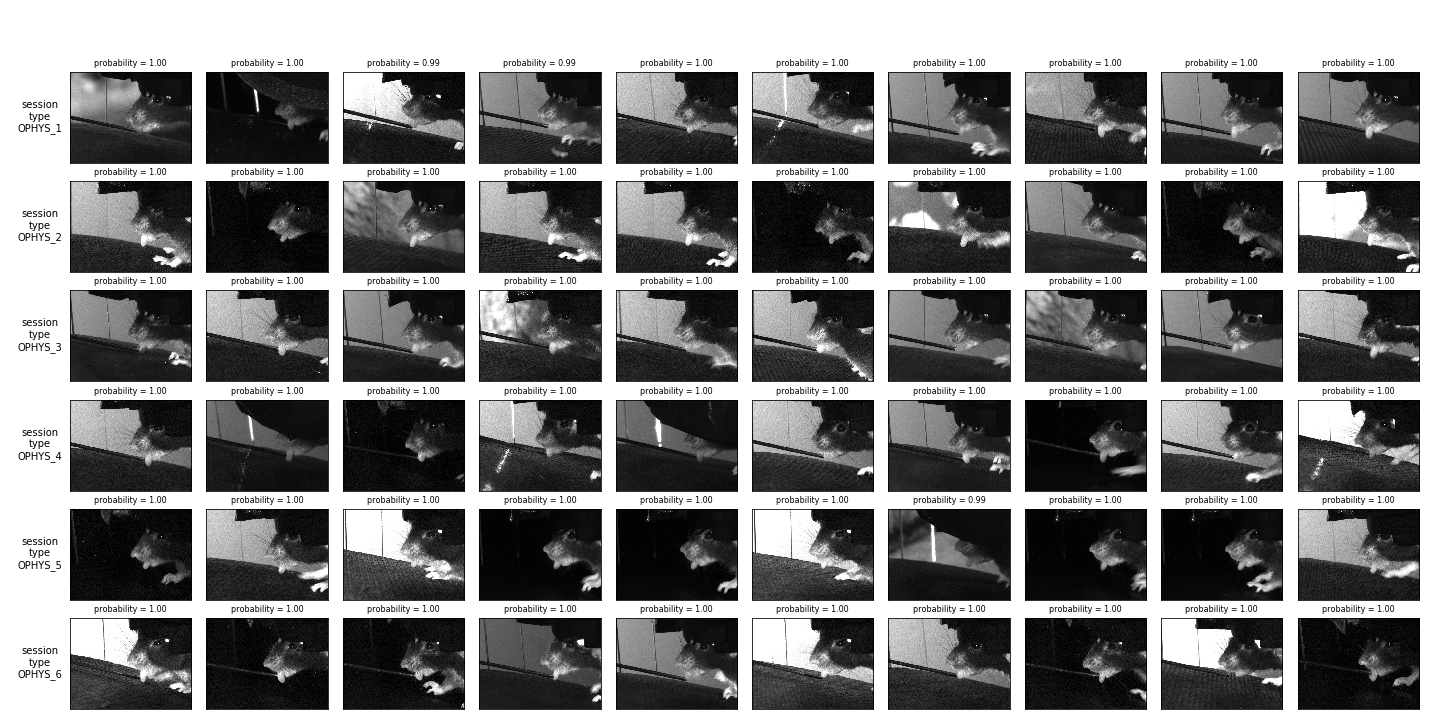

In [32]:
plot_examples_by_session(
    to_plot = 'lick', 
    low_bound_prob = 0.99, 
    high_bound_prob = 1
);

## look at high probability grooming bouts:
These also seem reasonable, but the same caveat about the lack of mesoscope data applies here.


<IPython.core.display.Javascript object>


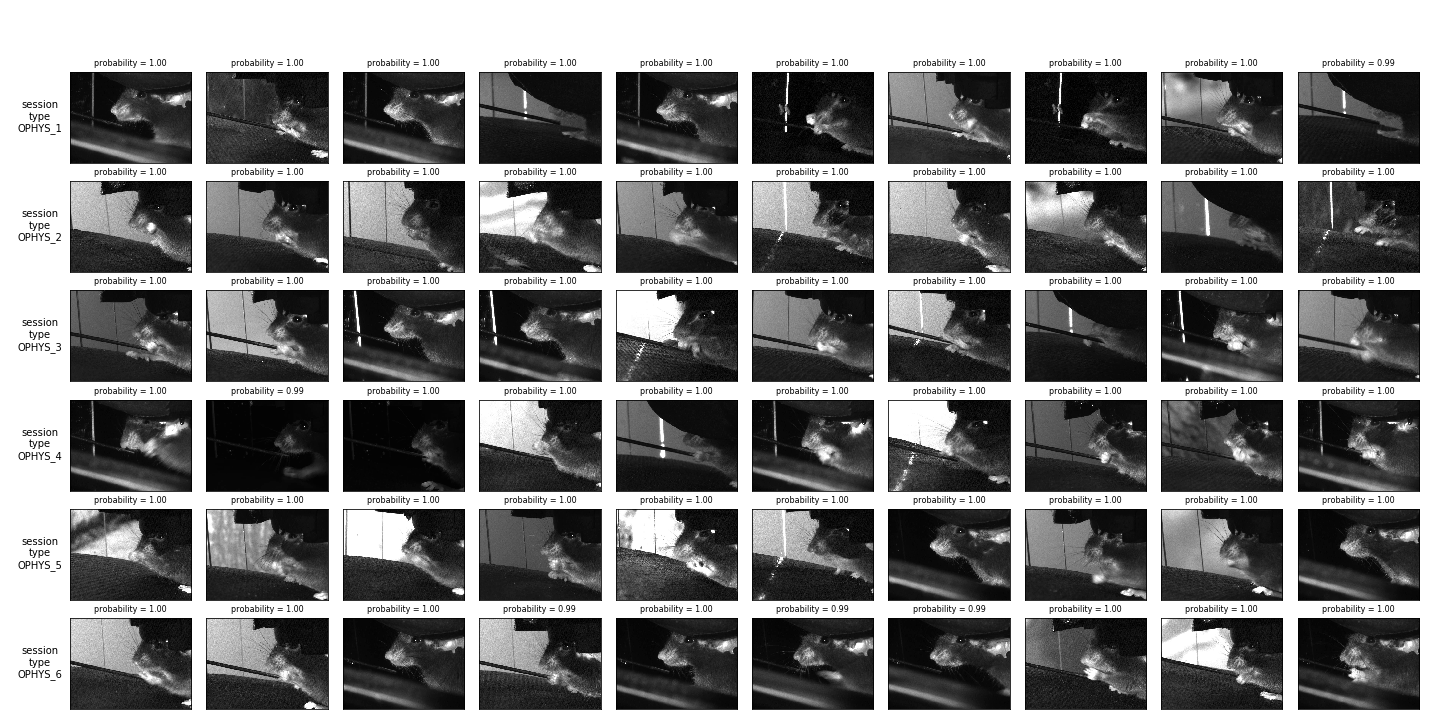

In [33]:
plot_examples_by_session(
    to_plot = 'groom', 
    low_bound_prob = 0.99, 
    high_bound_prob = 1
);

## look at lower probability licks:
Ther seem to be a fair number of mis-labeled frames here:
    * non-licks labeled as licks
    * grooms labeled as licks
    
One caveat, though. I've previously observed that the model has a somewhat uncanny ability to assign elevated licking probabilities to the frames immediately preceding and following actual licks. It's likely that there's some other feature of the face beyond just the presence of the tongue (maybe the whisker pad?) that the model is using to assign the licking probability.  

So while it looks like there are a lot of frames in that last image that are labeled 'lick' with high probability that obviously aren't licks, it may be that the animal just licked, or was just about to lick.

<IPython.core.display.Javascript object>


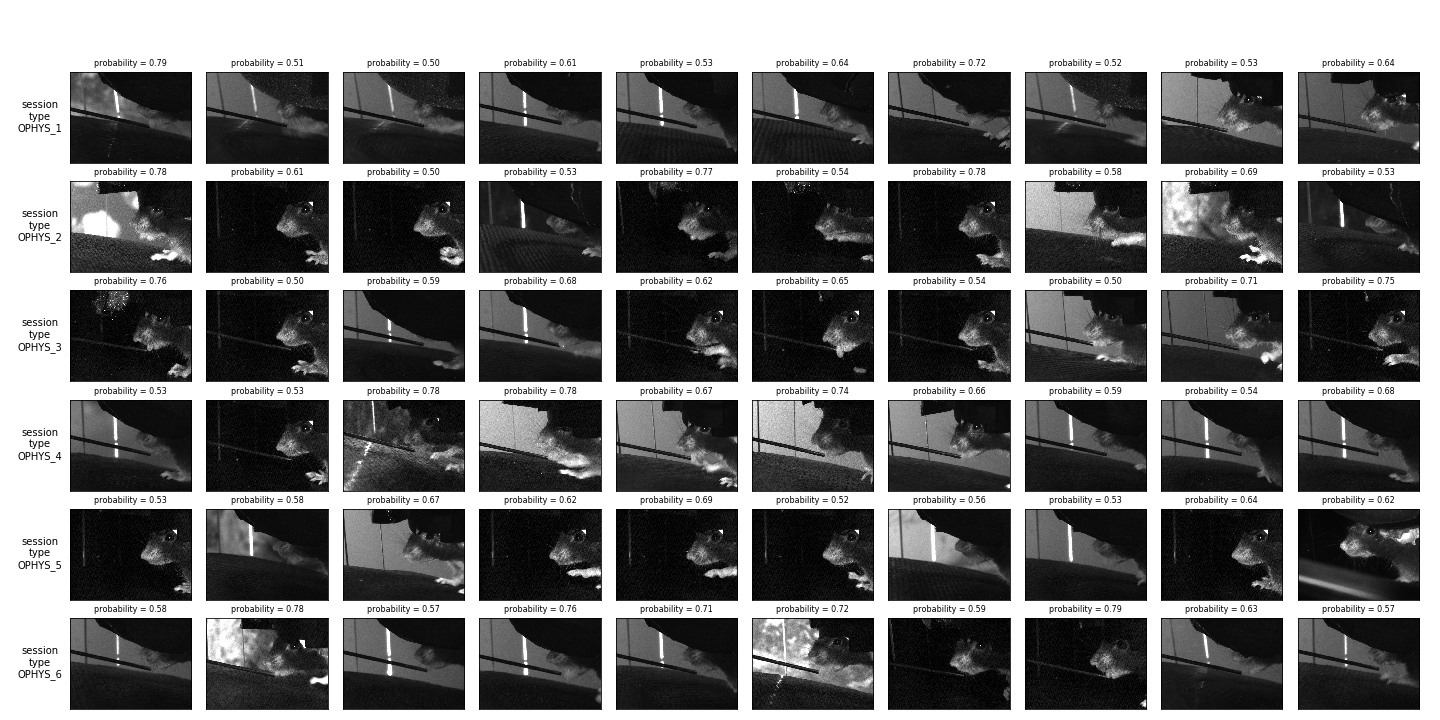

In [34]:
plot_examples_by_session(
    to_plot = 'lick', 
    low_bound_prob = 0.5, 
    high_bound_prob = 0.8
);

## look at lower probability grooms:
There also seem to be quite a few false positives here. 

<IPython.core.display.Javascript object>


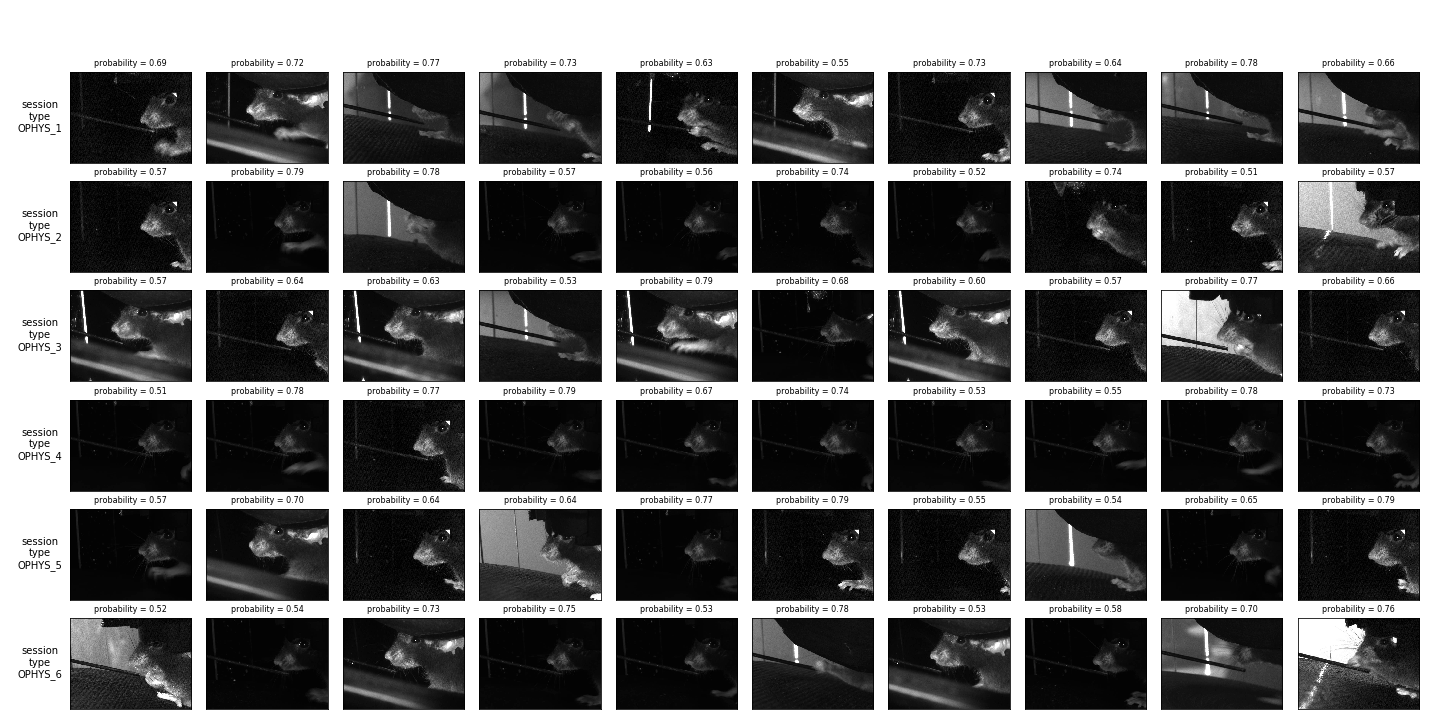

In [35]:
plot_examples_by_session(
    to_plot = 'groom', 
    low_bound_prob = 0.5, 
    high_bound_prob = 0.8
);

## look at the distribution of mean licking and grooming
The outliers likely represent problem sessions

<IPython.core.display.Javascript object>


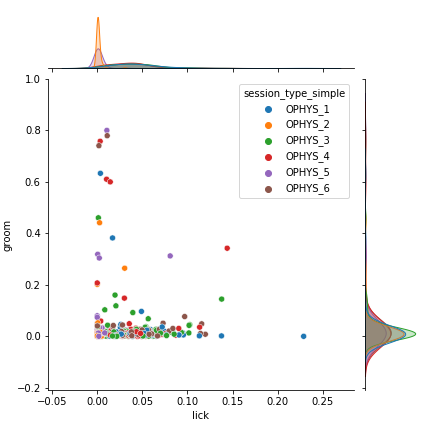

In [36]:
sns.jointplot(
    data = mean_probs,
    x='lick',
    y='groom',
    hue='session_type_simple',
    hue_order=np.sort(mean_probs['session_type_simple'].unique())
)

<IPython.core.display.Javascript object>


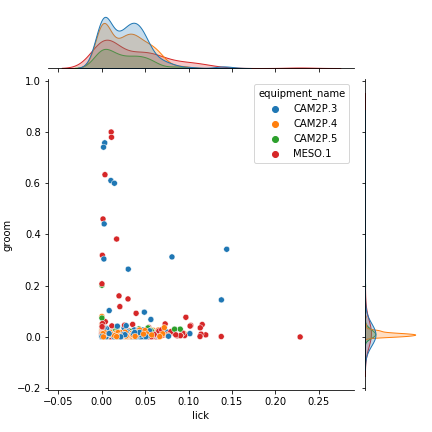

In [37]:
sns.jointplot(
    data = mean_probs,
    x='lick',
    y='groom',
    hue='equipment_name',
    hue_order=np.sort(mean_probs['equipment_name'].unique())
)

### look at sessions with mean groom probabilities above 0.5 (this is unlikely to be true!)

In [38]:
mean_probs.query('groom > 0.5')

ophys_session_id      lick     groom   neither  ophys_experiment_id  \
980         1052096166  0.003641  0.633574  0.362785           1052212181   
993         1056065360  0.010797  0.800195  0.189008           1056171522   
996         1056238781  0.011156  0.779704  0.209141           1057725798   
1001        1057486216  0.010470  0.610616  0.378914           1057706462   
1003        1058058727  0.014527  0.600171  0.385302           1058275574   
1004        1058683693  0.003371  0.757895  0.238734           1058813457   
1005        1059214492  0.001986  0.740912  0.257101           1059340828   

     equipment_name                                      full_genotype  \
980          MESO.1      Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
993          MESO.1      Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
996          MESO.1      Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
1001        CAM2P.3  Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   
1003        CAM2P.3  Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   
1004        CAM2P.3  Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   
1005        CAM2P.3  Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   

      mouse_id               reporter_line                      driver_line  \
980     528097  Ai148(TIT2L-GC6f-ICL-tTA2)                   [Vip-IRES-Cre]   
993     528097  Ai148(TIT2L-GC6f-ICL-tTA2)                   [Vip-IRES-Cre]   
996     528097  Ai148(TIT2L-GC6f-ICL-tTA2)                   [Vip-IRES-Cre]   
1001    539517          Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   
1003    539517          Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   
1004    539517          Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   
1005    539517          Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   

      ... prior_exposures_to_omissions  behavior_session_id  \
980   ...                            0           1052162546   
993   ...                            9           1056084114   
996   ...                           10           1056253022   
1001  ...                            7           1057533246   
1003  ...                            9           1058072139   
1004  ...                           11           1058696622   
1005  ...                           12           1059236465   

     ophys_container_id              project_code  imaging_depth  \
980          1052096570  VisualBehaviorMultiscope            225   
993          1052096554  VisualBehaviorMultiscope            150   
996          1052096554  VisualBehaviorMultiscope            158   
1001         1054675423      VisualBehaviorTask1B            175   
1003         1054675423      VisualBehaviorTask1B            175   
1004         1054675423      VisualBehaviorTask1B            175   
1005         1054675423      VisualBehaviorTask1B            175   

      targeted_structure         date_of_acquisition  \
980                 VISl  2020-09-22 10:43:29.464010   
993                 VISp  2020-10-12 09:12:40.151986   
996                 VISp  2020-10-13 09:46:25.940282   
1001                VISp  2020-10-19 16:04:21.000000   
1003                VISp  2020-10-21 16:15:28.000000   
1004                VISp  2020-10-23 16:36:28.000000   
1005                VISp  2020-10-26 16:22:24.000000   

                  session_type     file_id  session_type_simple  
980           OPHYS_1_images_A  1085402188              OPHYS_1  
993   OPHYS_5_images_B_passive  1085402232              OPHYS_5  
996           OPHYS_6_images_B  1085393860              OPHYS_6  
1001          OPHYS_4_images_A  1057815880              OPHYS_4  
1003          OPHYS_4_images_A  1058348900              OPHYS_4  
1004          OPHYS_4_images_A  1058852962              OPHYS_4  
1005          OPHYS_6_images_A  1059412930              OPHYS_6  

[7 rows x 27 columns]

<IPython.core.display.Javascript object>


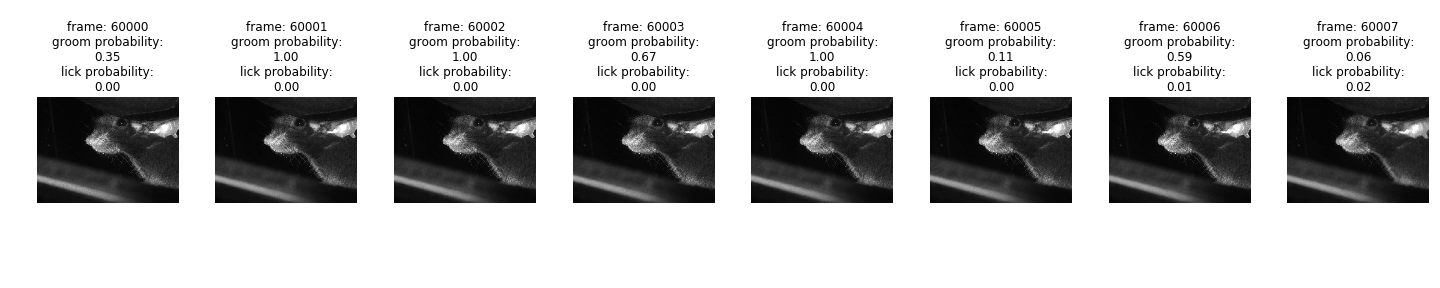

In [39]:
osid = 1056065360
first_frame = 60000
n_frames = 8
fig, ax = plt.subplots(1,n_frames,figsize=(20,4))
for i in range(n_frames):
    frame_number = first_frame + i
    plot_frame(osid, +i, ax[i])
    ax[i].axis('off')
    groom_prob = preds_df.query('ophys_session_id == @osid and frame_index == {}'.format(frame_number))['groom'].iloc[0]
    lick_prob = preds_df.query('ophys_session_id == @osid and frame_index == {}'.format(frame_number))['lick'].iloc[0]
    ax[i].set_title('frame: {}\ngroom probability:\n{:0.2f}\nlick probability:\n{:0.2f}'.format(frame_number, groom_prob, lick_prob))
fig.tight_layout()

### Note that this particular session has no examples in the train/test/validate set

In [40]:
all_image_table.query('session_id == @osid')

Empty DataFrame
Columns: [frame_number, label, session_id, train_test_validate]
Index: []

### one more example

<IPython.core.display.Javascript object>


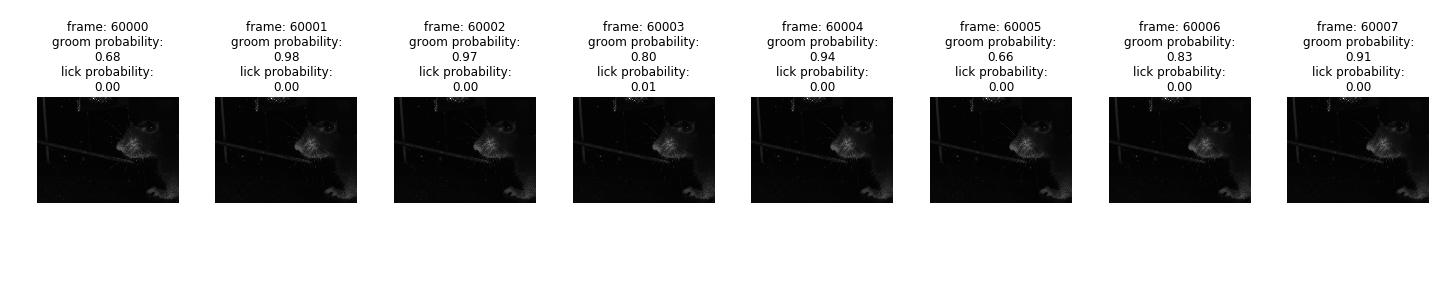

In [41]:
osid = 1058683693
first_frame = 60000
n_frames = 8
fig, ax = plt.subplots(1,n_frames,figsize=(20,4))
for i in range(n_frames):
    frame_number = first_frame + i
    plot_frame(osid, +i, ax[i])
    ax[i].axis('off')
    groom_prob = preds_df.query('ophys_session_id == @osid and frame_index == {}'.format(frame_number))['groom'].iloc[0]
    lick_prob = preds_df.query('ophys_session_id == @osid and frame_index == {}'.format(frame_number))['lick'].iloc[0]
    ax[i].set_title('frame: {}\ngroom probability:\n{:0.2f}\nlick probability:\n{:0.2f}'.format(frame_number, groom_prob, lick_prob))
fig.tight_layout()

In [42]:
all_image_table.query('session_id == @osid')

Empty DataFrame
Columns: [frame_number, label, session_id, train_test_validate]
Index: []

In [43]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [44]:
mean_probs.query('session_type_simple == "OPHYS_2" and lick > 0.001 and lick < 0.1')

ophys_session_id      lick     groom   neither  ophys_experiment_id  \
51           843049997  0.001368  0.020267  0.978364            843519218   
60           847758278  0.002178  0.000576  0.997246            848039121   
68           848891498  0.004726  0.004410  0.990864            849199228   
143          870352564  0.006490  0.006850  0.986660            875564408   
440          931326814  0.001335  0.003640  0.995025            932372699   
446          932664150  0.001449  0.002506  0.996045            933338719   
488          938898514  0.001263  0.004070  0.994668            939471259   
521          942384133  0.001126  0.027596  0.971278            943134119   
536          947199653  0.001174  0.002300  0.996526            947798783   
636          962736894  0.001323  0.006043  0.992634            963394081   
737          979968637  0.006058  0.007882  0.986061            980673831   
753          982980548  0.001011  0.000421  0.998568            984551228   
835          992396398  0.001188  0.030571  0.968242            992572516   
879          993984066  0.002423  0.002563  0.995014            994053903   
902         1004014391  0.002288  0.014949  0.982763           1004136916   
919         1010373053  0.004898  0.000997  0.994105           1010530054   
929         1038779134  0.001674  0.008867  0.989459           1038848242   
934         1042279538  0.004014  0.013041  0.982944           1042387062   
938         1043063803  0.009307  0.011733  0.978960           1043218895   
967         1050623160  0.030483  0.264726  0.704791           1050720434   
1000        1056972086  0.002714  0.441355  0.555931           1057070365   
1007        1059624695  0.003837  0.015972  0.980191           1059768347   

     equipment_name                                      full_genotype  \
51          CAM2P.3  Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   
60           MESO.1      Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
68          CAM2P.4  Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   
143          MESO.1      Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
440          MESO.1      Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
446         CAM2P.3      Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
488          MESO.1      Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
521         CAM2P.4      Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
536          MESO.1      Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
636         CAM2P.3      Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
737         CAM2P.3      Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
753         CAM2P.3      Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
835         CAM2P.3      Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
879         CAM2P.4      Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
902         CAM2P.4      Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
919         CAM2P.3      Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
929         CAM2P.3  Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   
934         CAM2P.3  Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   
938         CAM2P.4      Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
967         CAM2P.3      Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
1000        CAM2P.3  Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   
1007        CAM2P.4  Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   

      mouse_id               reporter_line                      driver_line  \
51      440298          Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   
60      438912  Ai148(TIT2L-GC6f-ICL-tTA2)                   [Vip-IRES-Cre]   
68      436662          Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   
143     449653  Ai148(TIT2L-GC6f-ICL-tTA2)                   [Vip-IRES-Cre]   
440     453988  Ai148(TIT2L-GC6f-ICL-tTA2)                   [Vip-IRES-Cre]   
446     467951  Ai148(TIT2L-GC6f-ICL-tTA2)               

In [45]:
preds_df.query('ophys_session_id == 1010373053 and lick > 0.9').iloc[:100]

frame_index         groom      lick   neither  timestamps  \
40752196           68  3.406458e-04  0.999570  0.000089     2.36609   
40752197           69  4.311683e-04  0.999463  0.000106     2.39888   
40752208           80  1.597033e-06  0.999954  0.000044     2.76779   
40755074         2946  1.525937e-04  0.984878  0.014969    98.30023   
40755081         2953  7.276329e-04  0.999089  0.000183    98.53239   
40755225         3097  4.136915e-04  0.989453  0.010133   103.33933   
40755226         3098  6.464877e-06  0.999856  0.000138   103.36550   
40755231         3103  5.029757e-03  0.935305  0.059665   103.53250   
40755433         3305  5.611704e-04  0.925837  0.073602   110.26585   
40755434         3306  9.198196e-06  0.999971  0.000020   110.29909   
40755439         3311  5.342519e-05  0.983352  0.016594   110.46584   
40756020         3892  9.425016e-05  0.999860  0.000046   129.83273   
40756021         3893  5.350584e-05  0.999934  0.000013   129.86590   
40756022         3894  1.047677e-03  0.963629  0.035323   129.89914   
40756026         3898  8.523971e-04  0.927982  0.071165   130.03236   
40756290         4162  4.537000e-05  0.967742  0.032213   138.83237   
40756291         4163  1.004623e-05  0.999974  0.000016   138.86580   
40757092         4964  1.268035e-05  0.999137  0.000850   165.56586   
40757093         4965  2.066595e-05  0.999678  0.000301   165.59908   
40757290         5162  1.625386e-04  0.999793  0.000045   172.16582   
40757291         5163  2.988524e-04  0.999617  0.000084   172.19926   
40757297         5169  5.157348e-05  0.999924  0.000024   172.39956   
40757298         5170  1.845650e-04  0.999129  0.000686   172.44157   
40757460         5332  1.551020e-03  0.961879  0.036570   177.83273   
40757461         5333  9.222394e-04  0.998695  0.000382   177.86601   
40757791         5663  2.684615e-04  0.998575  0.001156   188.86603   
40757792         5664  2.891833e-05  0.999957  0.000014   188.89938   
40758580         6452  1.423521e-04  0.999797  0.000061   215.16599   
40758705         6577  5.807463e-05  0.987546  0.012396   219.33248   
40758706         6578  1.847295e-05  0.931837  0.068145   219.36573   
40758826         6698  6.767361e-06  0.996745  0.003248   223.36596   
40758966         6838  6.817986e-05  0.950616  0.049316   228.03247   
40758967         6839  1.770349e-04  0.963297  0.036526   228.06574   
40758973         6845  2.805147e-05  0.999644  0.000328   228.26604   
40759188         7060  7.503849e-03  0.966264  0.026232   235.43493   
40759189         7061  1.020132e-04  0.999871  0.000027   235.46589   
40759483         7355  4.507777e-05  0.999749  0.000206   245.26614   
40759621         7493  2.349316e-04  0.994199  0.005566   249.86608   
40759622         7494  1.266816e-04  0.999498  0.000376   249.89945   
40759760         7632  4.894842e-05  0.999930  0.000021   254.50020   
40759761         7633  1.121229e-04  0.999761  0.000127   254.53280   
40759926         7798  8.730527e-05  0.999771  0.000141   260.03262   
40759927         7799  1.007504e-03  0.997362  0.001630   260.06589   
40759932         7804  5.848520e-06  0.999987  0.000007   260.23268   
40759942         7814  2.936258e-04  0.999420  0.000287   260.56605   
40760181         8053  1.743880e-05  0.999732  0.000251   268.53277   
40760182         8054  6.382340e-05  0.998514  0.001422   268.56608   
40760186         8058  9.908828e-07  0.999893  0.000106   268.69921   
40760361         8233  6.819220e-05  0.993007  0.006925   274.53282   
40760364         8236  8.245849e-05  0.999538  0.000379   274.63262   
40760365         8237  1.161329e-06  0.999872  0.000127   274.66601   
40760370         8242  7.383932e-07  0.999889  0.000111   274.83280   
40760375         8247  8.748570e-06  0.999105  0.000886   275.00051   
40760591         8463  1.523790e-05  0.976551  0.023433   282.19958   
40760761         8633  2.529786e-05  0.999926  0.000048   287.86632   
40760762         8634  8.262651e-0

<IPython.core.display.Javascript object>


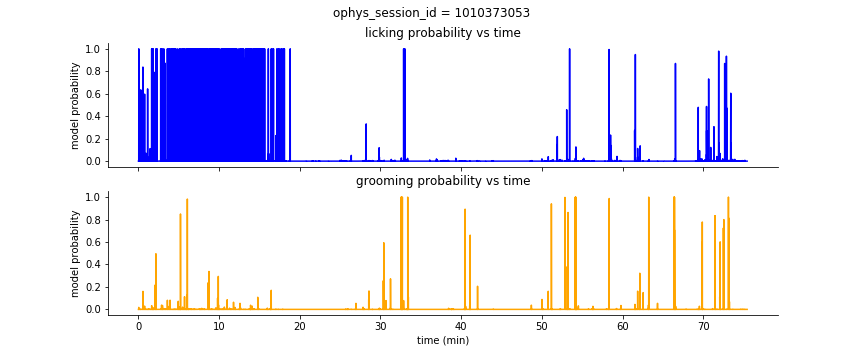

Text(0.5, 0.98, 'ophys_session_id = 1010373053')

In [46]:
osid = 1010373053
x = 'timestamps'

fig, ax = plt.subplots(2, 1, figsize = (12,5), sharex=True)
ax[0].plot(
    preds_df.query('ophys_session_id == @osid')[x]/60,
    preds_df.query('ophys_session_id == @osid')['lick'],
    color='blue'
)
ax[0].set_title('licking probability vs time')
ax[0].set_ylabel('model probability')
ax[1].plot(
    preds_df.query('ophys_session_id == @osid')[x]/60,
    preds_df.query('ophys_session_id == @osid')['groom'],
    color='orange'
)
ax[1].set_title('grooming probability vs time')
ax[1].set_ylabel('model probability')
ax[1].set_xlabel('time (min)')
sns.despine()
fig.suptitle('ophys_session_id = {}'.format(osid))

In [47]:
list(np.sort([a for a in annotations['username'].unique() if a not in [None, 'unknown', '']]))

NameError: name 'annotations' is not defined

In [ ]:
all_image_table.query('label == "ambiguous"').sample(8)

<IPython.core.display.Javascript object>


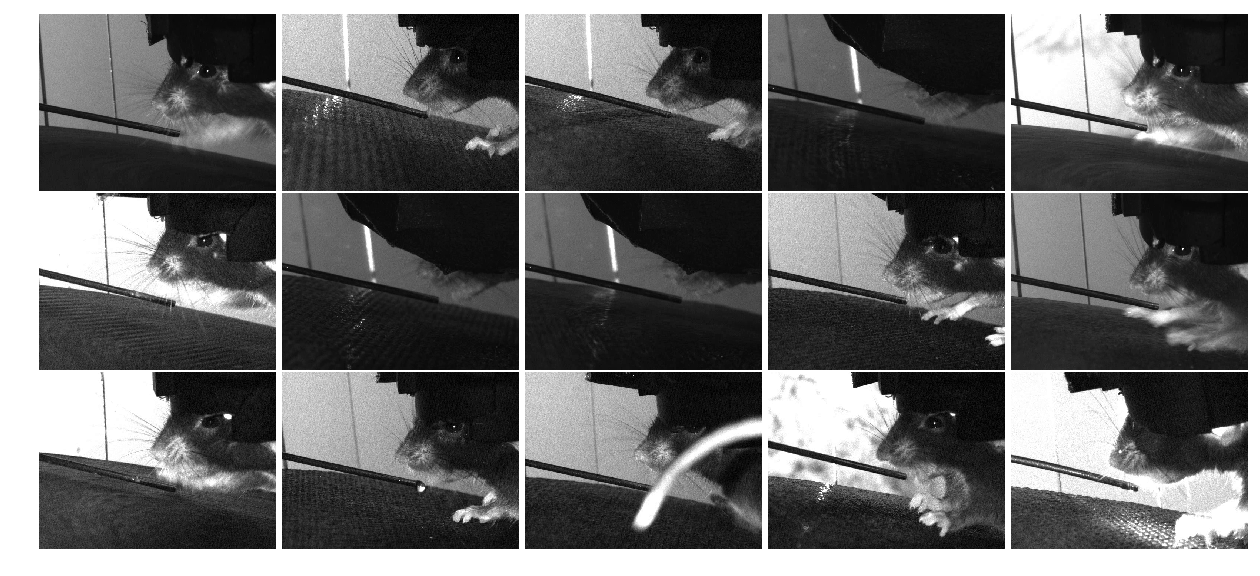

In [52]:
n_frames = 15
fig, ax = plt.subplots(3,5,figsize=(17.5,8))
for idx, row in all_image_table.query('label == "ambiguous"').sample(n_frames, random_state=0).reset_index().iterrows():
    plot_frame(row['session_id'], row['frame_number'], ax.flatten()[idx])
    ax.flatten()[idx].axis('off')
fig.tight_layout()
fig.subplots_adjust(hspace=0.01, wspace =0.01)


In [ ]:
row['ophys_session_id']

<IPython.core.display.Javascript object>


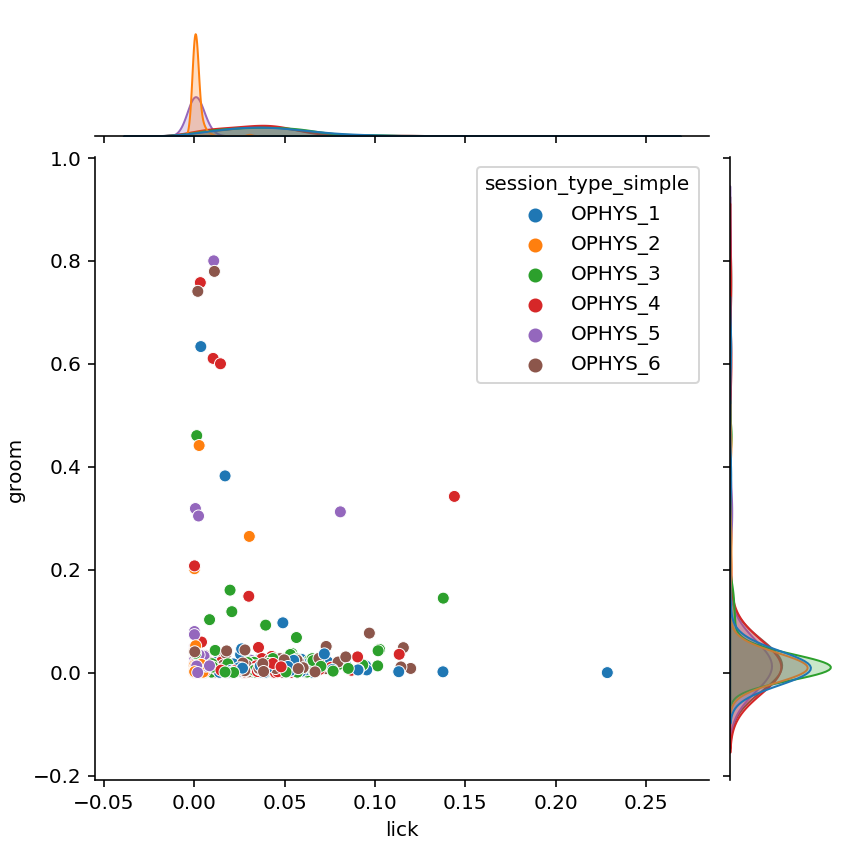

In [53]:
sns.jointplot(
    data = mean_probs,
    x='lick',
    y='groom',
    hue='session_type_simple',
    hue_order=np.sort(mean_probs['session_type_simple'].unique())
)

In [54]:
mean_probs

ophys_session_id          lick     groom   neither  ophys_experiment_id  \
0            775289198  4.912261e-03  0.000062  0.995025            775614751   
1            778015591  2.328573e-05  0.000138  0.999839            778644591   
2            787661032  1.586138e-02  0.010784  0.973355            788490510   
3            792327341  6.535848e-02  0.000536  0.934105            792813858   
4            792619807  5.980199e-02  0.005939  0.934259            792815735   
5            793857113  6.182731e-02  0.000505  0.937668            794381992   
6            794474159  5.104836e-02  0.002102  0.946849            795076128   
7            794918442  5.812953e-02  0.009099  0.932772            795073741   
8            795217244  1.624258e-03  0.003141  0.995235            795952471   
9            795625712  4.510687e-02  0.008670  0.946223            795953296   
10           796018019  2.003807e-04  0.002475  0.997325            796106850   
11           796019065  7.276639e-02  0.007739  0.919495            796105304   
12           796044280  1.158847e-03  0.003907  0.994934            796108483   
13           796236521  5.069896e-02  0.006294  0.943007            796308505   
14           798007990  7.144827e-04  0.008486  0.990800            798404219   
15           803223329  3.611261e-02  0.025773  0.938114            803736273   
16           805269503  4.280014e-02  0.031456  0.925744            805784331   
17           805989030  5.488721e-02  0.018394  0.926719            806456687   
18           806203732  5.930641e-02  0.025918  0.914776            806455766   
19           806812738  3.650071e-04  0.025935  0.973700            806989729   
20           807055274  1.464423e-04  0.032699  0.967155            807753318   
21           807208045  4.665296e-02  0.023257  0.930090            807752719   
22           807393193  6.344930e-02  0.022948  0.913603            807753334   
23           808092249  3.922540e-02  0.024671  0.936104            808621958   
24           808107961  3.291474e-02  0.012350  0.954735            808619543   
25           808340530  4.243963e-02  0.024639  0.932922            808621034   
26           809261351  1.097505e-04  0.040508  0.959382            809497730   
27           809393834  4.961912e-02  0.024642  0.925739            809501118   
28           811234448  4.963595e-05  0.005569  0.994382            811456530   
29           811310092  1.031253e-04  0.049715  0.950182            811458048   
30           812802821  2.270471e-02  0.014608  0.962688            813083478   
31           815485890  1.164006e-04  0.022671  0.977213            815652334   
32           817101568  2.334604e-02  0.010159  0.966495            817267785   
33           819949602  3.057059e-02  0.014285  0.955145            820307518   
34           822388759  4.083156e-02  0.015230  0.943938            822647135   
35           824745199  4.909790e-02  0.019326  0.931576            825130141   
36           825682242  6.416789e-03  0.010426  0.983157            826587940   
37           829521794  6.270745e-04  0.010925  0.988448            830093338   
38           830148632  1.280347e-04  0.013679  0.986193            830700800   
39           830272668  3.854389e-02  0.012535  0.948921            830700781   
40           831761261  9.167806e-05  0.011015  0.988893            832115263   
41           832881662  8.129198e-05  0.010310  0.989608            833631914   
42           833002992  1.454202e-02  0.034642  0.950816            833629926   
43           833812106  1.269588e-02  0.009254  0.978050            834279496   
44           834887125  6.495743e-02  0.005645  0.929398            835006071   
45           835795999  1.677582e-04  0.007847  0.991985            836258957   
46           835796136  2.677663e-02  0.015165  0.958058            836258936   
47           836322359  1.579041e-04  0.012367  0.987475            836911939   
48           836962545  3.329451e-04 